# Time series: stationarity and sample autocorrelation function

In this notebook we build some canonical examples of time series and try to relate to the concept of stationarity

### Resources:
- https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
- https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/
- https://stats.stackexchange.com/questions/225087/seasonal-data-deemed-stationary-by-adf-and-kpss-tests


In [75]:
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller, kpss

# random numbers generator
rng = np.random.RandomState(24321)

# Stationarity

A series is weakly stationary when 
$$
\mu(t) = \mu = \text{const.}
$$
and
$$
\gamma_x(t+h, t) = \text{Cov}(x(t+h), x(t)) = \gamma_x(h)
$$


## In case you haven't noticed...

In time series theory, each $x(t)$ is regarded as a different random variable. As such, when saying $\mu(t) = \text{const}$ we intend that each of these, potentially independent, RVs all happen to have same mean. Verifying this, however, is *tough*, as we typically only have a single occurrence of each RV. This concept is expanded further next.

Imagine that we have 2 RV, $a$ and $b$. These represent two consecutive time steps of a time series, but we intentionally give them different names for explanatory purposes. 
In statistics, we would check that these have the same mean by running a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test). We would start from two samples for $a$ and $b$ and we would then infer whether their underlying distributions are significantly different or not. Note that we compute the sample means, $\mu_a$ and $\mu_b$, 

In time series analysis, we can't do that as we normally have a single occurrence of a time series. Say we had $P$ time series of length $N$, all coming from the same process - e.g. the first 30 seconds of turning on an engine, or similar. Well, in this case, for each $x(t)$ I have $P$ observations. I can hence verify the stationarity hypothesis running a sequence of t-test between $x(t)$ and $x(t+\Delta t)$ etc, until I disprove the stationarity hypothesis.

In practice, as we only have a single occurrence of a time series, the approach above is unfeasible. Somehow, it is like we are assuming that each $x(t)$ is an observation of a different random variable - and as you only have a unique observation, what statistical inference can you ever do?


## Sample mean

As in practical time series problems we start from a time series observation, we often rely on **sample mean**, $\bar{x}$, and **sample autocovariance/autocorrelation** $\hat\gamma(h)$ and $\rho(h)$, defined as:
$$
\bar{x} = \frac{1}{N} \sum^N x_t
$$
and 
$$
\hat\gamma(h) = \frac{1}{N} \sum_{1}^{N-|h|} (x_{t+|h|} - \bar{x}) (x_{t} - \bar{x}) 
\quad , \quad 
\rho(h) = \frac{\hat\gamma(h)}{\hat\gamma(0)}
$$


Note that especially the sample mean can be confused with the mean of a sample of observed data from a unique RV (see discussion above). Instead, $\bar{x}$ is the mean of a sample from a process, namely a unique observation from a sequence of different RVs.

# Noise, trend and seasonality

This is a useful test case for fixing some of the concepts above and also to see how to test for stationarity in real life.

We define a time series as:
$$
x(t) = A \, m(t) + B \, sin(\omega t) + N(0,\sigma^2)
$$

This time series **is not stationary** whenever $A\neq0$ (trend) or $B\neq 0$, as its mean is:
$$
\mu = \mu(t) = A \, m(t) + B \, \sin(\omega t) \neq \text{const}
$$
is not constant. 

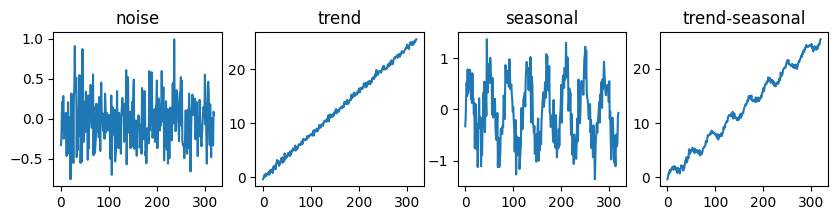

In [76]:
sigma = .3
period_size, n_periods = 40, 8
omega = 2.*np.pi/period_size
n_sample = period_size*n_periods
tv = np.arange(n_sample)

xv_dict = {  "noise": rng.normal(0, sigma, size=(n_sample,)) }
xv_dict["trend"] = 0.08*tv + xv_dict["noise"]
xv_dict["seasonal"] =  .7*np.sin(omega*tv) + xv_dict["noise"]
xv_dict["trend-seasonal"] = 0.08*tv + np.sin(omega*tv) + xv_dict["noise"]
    
fig = plt.figure(figsize=(10,2))
Ax = fig.subplots(1,len(xv_dict),squeeze=False)
for ii,(key,xv) in enumerate(xv_dict.items()):
    Ax[0,ii].plot(tv, xv)
    Ax[0,ii].set_title(key)

### Testing for stationarity: ADF and KPSS tests

Knowing that the time series is not stationary (unless $A=B=0$), we use the augmented Dickey Fuller (ADF) and the KPSS tests. 

The null hypothesis for these tests is opposite:
- ADF: $H_0$: the time series has a unit root. Hence if the p-value is $p \ll 1$, the time series is stationary.
- KPSS: $H_0$: the time series is stationary *around a deterministic trend* (see below). Hence, if p-value is $p \ll 1$ the series **is not** stationary.

*Reminder:* the p-value is the probability of observing the occurrence if the null hypothesis is true. Hence, if p-value is small, we reject $H_0$ and accept $H_1$

**Note** that in `statsmodels`, we have the option to check stationarity *around a trend* using `regression="ct"`; this checks for stationarity around a trend - namely, the function will remove a (linear) trend behind the hook and check stationarity on the residual. For ADF we even have a `"ctt"` option to check for stationarity around quadratic trends. 

**Results**

- **Both tests correctly detect stationarity for the noise and trend + noise functions**. In the latter case, this is because we are using the `regression="ct"` flag - hence the function removes the trend and checks that the residual (noise) is stationary.

- **Both tests fail to detect that the time series in not stationary when there is a seasonal component**. In general, as explained [here](https://stats.stackexchange.com/questions/225087/seasonal-data-deemed-stationary-by-adf-and-kpss-tests) *test are tailored for detecting nonstationarity in the form of a unit root in the process. (The test equations explicitly allow for a unit root; see the refence below.) However, they are not tailored for detecting other forms of nonstationarity*

**Overall ADF and KRSS are reliable only if first you have removed any seasonal deterministic trend from the time series**.

In [77]:
%%capture --no-stdout
significance = 0.05

for key, xv in xv_dict.items():
# key = "noise"
# xv = xv_dict[key]

    print(5*"-" + f" {key}")

    results = adfuller(xv, regression="ct")
    statistic, p_value = results[:2]

    is_stationary_str = "is not stationary"
    if p_value<significance:
        is_stationary_str = "is stationary"
    print(f'ADF test: time series {is_stationary_str} (p-value: {p_value:.3f} | stat: {statistic:.3f})')
    # print('ADF Critical Values:')
    # for key, value in result[4].items():
    #     print('\t%s: %.3f' % (key, value))

    statistic, p_value, n_lags, critical_values = kpss(xv, regression="ct" )
    is_stationary_str = "is stationary"
    if p_value<significance:
        is_stationary_str = "is not stationary"
    print(f'KPPS test: time series {is_stationary_str} (p-value: {p_value:.3f} | stat: {statistic:.3f})')

----- noise
ADF test: time series is stationary (p-value: 0.000 | stat: -17.044)
KPPS test: time series is stationary (p-value: 0.100 | stat: 0.034)
----- trend
ADF test: time series is stationary (p-value: 0.000 | stat: -17.044)
KPPS test: time series is stationary (p-value: 0.100 | stat: 0.034)
----- seasonal
ADF test: time series is stationary (p-value: 0.000 | stat: -9.224)
KPPS test: time series is stationary (p-value: 0.100 | stat: 0.022)
----- trend-seasonal
ADF test: time series is stationary (p-value: 0.000 | stat: -9.682)
KPPS test: time series is stationary (p-value: 0.100 | stat: 0.021)


## Sample Autocorrelation Function

Below we look at the sample autocorrelation function (ACF), $\hat\rho$ for the main cases studied. Note that the sample autocorrelation function can be computed always, not just for stationary time series. We comment here on the key feature of $\hat\rho$. **Overall we see that for non-stationary time series the sample ACF shows very slow decay, or no decay at all and periodicity when there is seasonality.**

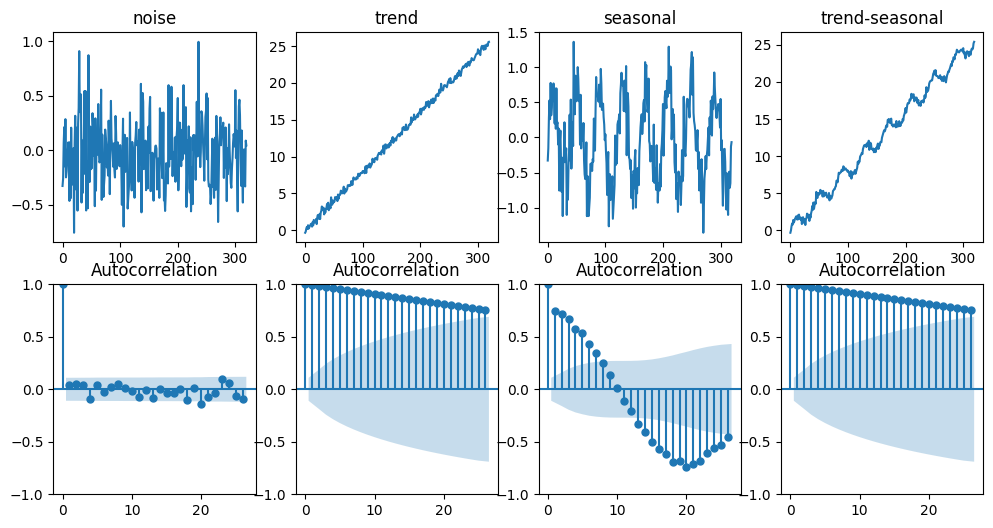

In [78]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plt.figure(figsize=(12,6))
Ax = fig.subplots(2,len(xv_dict),squeeze=False)
for ii,(key,xv) in enumerate(xv_dict.items()):
    Ax[0,ii].plot(tv, xv)
    Ax[0,ii].set_title(key)

    plot_acf(xv, ax=Ax[1,ii], alpha=0.05)

For each given lag $h$, the sample autocorrelation will give a measure of the similarities of the values at $x(t+h)$ and $x(t)$. Look at its form
$$
\hat\gamma(h) = \frac{1}{N} \sum_{1}^{N-|h|} (x_{t+|h|} - \bar{x}) (x_{t} - \bar{x}) 
\quad , \quad 
\rho(h) = \frac{\hat\gamma(h)}{\hat\gamma(0)}
$$
And in particular at the term $(x_{t+|h|} - \bar{x}) (x_{t} - \bar{x})$. Assume for simplicity of thought that $\bar{x}=0$. If we see that (say) $x_{t+|h|} - \bar{x} = x_{t+|h|}$ is (on average, across all $t$) half $x_{t} - \bar{x} = x_{t}$ then we can infer that the time series tends to halve when going from $t \to t + h$. 

This is what happens both in the trend and seasonal AC plots. In a trend, $x(t)$ is rising, so when we compare $x(t)$ and $x(t+h)$ we see that one is a fraction of the other. 
- For the trend, $\rho(h)$ decays with the lag $h$: $x(t)$ is smaller and smaller that $x(t+h)$ due to the increasing trend (or vice versa, the $\rho(h) is symmetric$). 
- For the seasonal component, instead, the $\rho(h)$ is periodic, with the same period as $x(t)$.  Note that there is a drop from $h=0$ to $h=1$, then the plot is smooth. This drop is due to the fact that we have some noise as well - **we would not see it if the signal was perfectly deterministic**.

**Overall we can say that for non-stationary time series, the sample ACF shows very slow decay, or no decay at all and periodicity when there is seasonality.**
